In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)



/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


In [2]:
import pertpy

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [3]:
# import from scfair-reproducibility
from dis2pm_dev.scfair_reproducibility.benchmark_VAE.vi import VI
from dis2pm_dev.scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from dis2pm_dev.scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker


In [4]:
from dis2p.dis2pvae import *
from dis2p.dis2pvi import *
from dis2p.ood import *
from dis2p.trainingplan import *
from dis2p.utils import *

import dis2p.dis2pvae_cE as dvae
import dis2p.dis2pvi_cE as dvi

## Train Dis2p

In [5]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

# preprocess dataset
adata = pertpy.data.kang_2018() #scvi.data.heart_cell_atlas_subsampled()
#adata = sc.read("/nfs/team205/sm58/packages/dis2p_trials/scfair/data/hca_subsampled_20k.h5ad")
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'KangBlood'

# specify attributes
cats = ['label', 'cell_type']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [31]:
# train params
epochs = 80
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:
    Dis2pVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = Dis2pVI(adata, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     File                                                                                                      
         models/dis2p/2024-01-16,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_wei
         ght=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                  


In [9]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,{data_name},n_layers=1,max_epochs={epochs},batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)



INFO     File                                                                                                      
         models/dis2p/2024-01-16,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_wei
         ght=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                  


In [32]:
adata.obsm[f'{module_name}'] = model.get_latent_representation(adata, nullify_cat_covs_indices=[0], nullify_shared=True)


In [10]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
#warnings.simplefilter('ignore', category=NumbaWarning)

---UMAP for dis2p_Z_0---


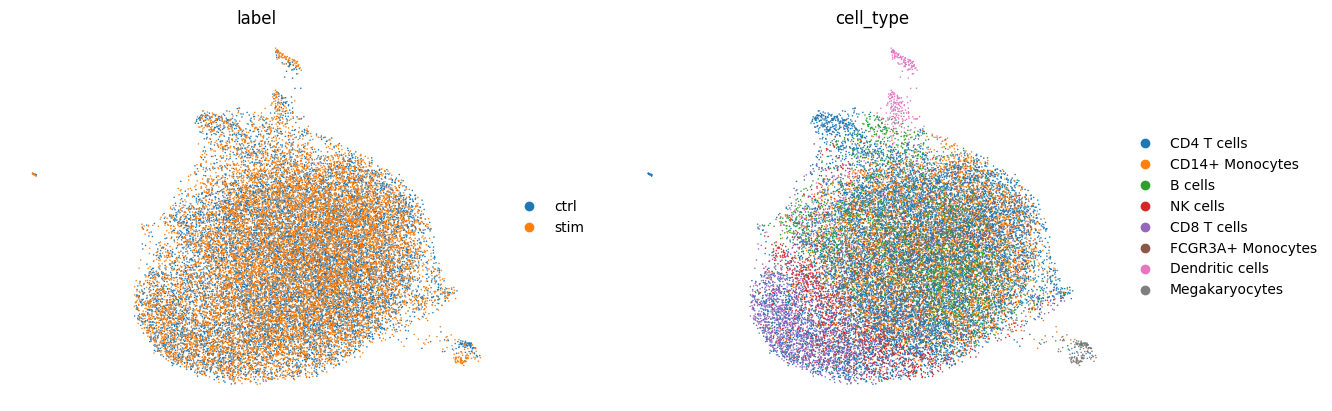

---UMAP for dis2p_Z_1---


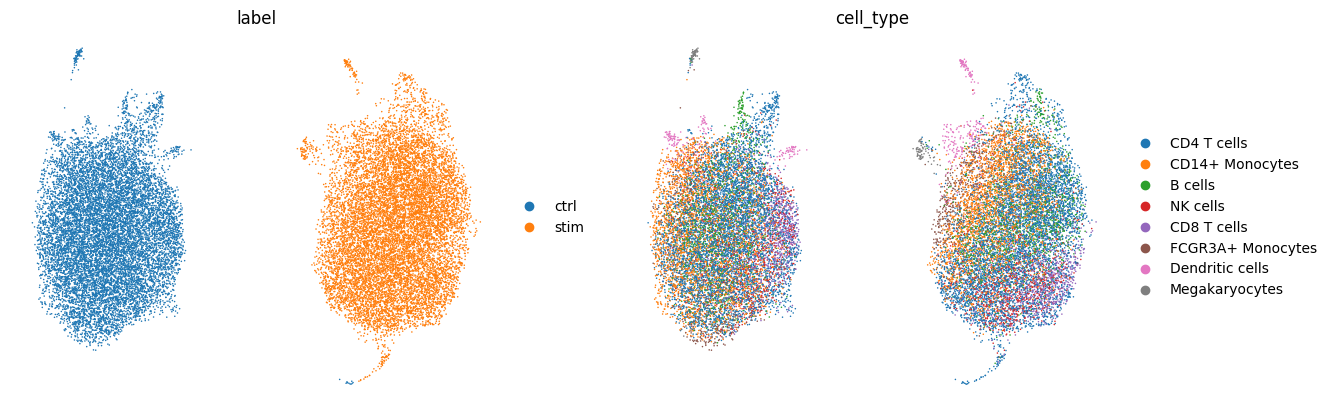

---UMAP for dis2p_Z_2---


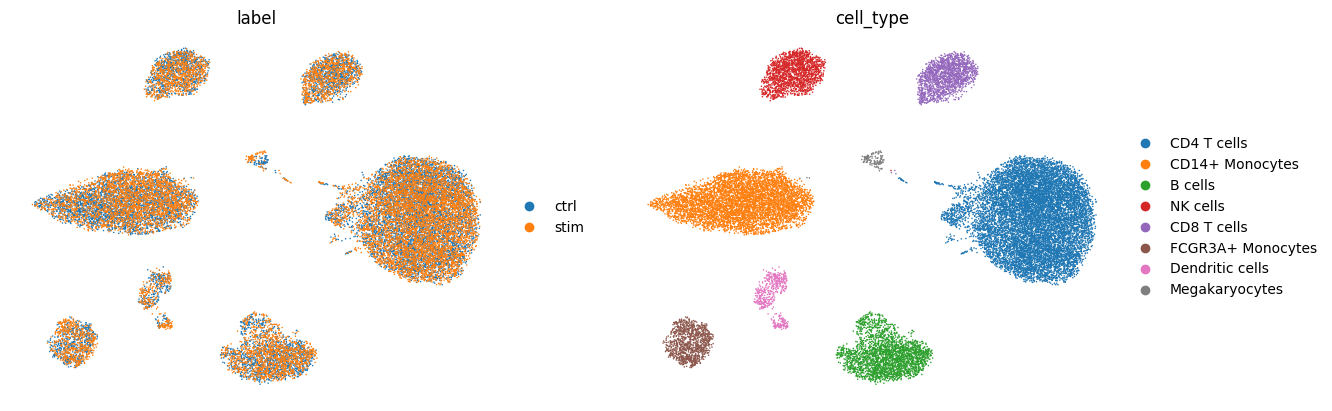

In [11]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## Train dis2p_cE version

In [33]:
module_name = 'dis2p_cE'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:
    dvi.Dis2pVI_cE.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = dvi.Dis2pVI_cE(adata, n_layers=n_layers)
    model.train(**train_dict)


INFO     File                                                                                                      
         models/dis2p_cE/2024-01-16,dis2p_cE,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,c
         lf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                            


In [19]:
model.save(f"{pre_path}/{model_name}")

In [20]:
# load model
model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)



INFO     File                                                                                                      
         models/dis2p_cE/2024-01-16,dis2p_cE,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,c
         lf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                            


In [34]:
adata.obsm[f'{module_name}'] = model.get_latent_representation(adata, nullify_cat_covs_indices=[0], nullify_shared=True)


---UMAP for dis2p_cE_Z_0---


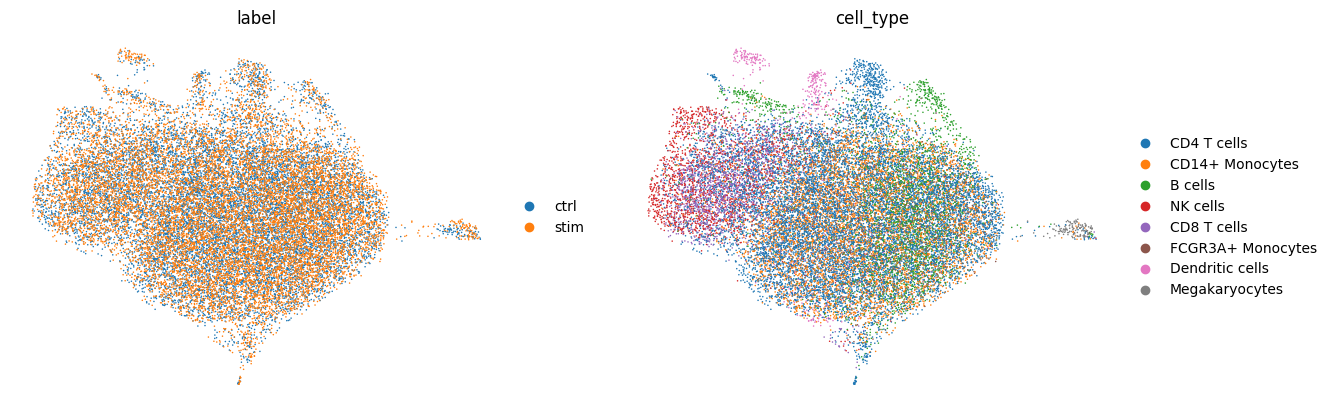

---UMAP for dis2p_cE_Z_1---


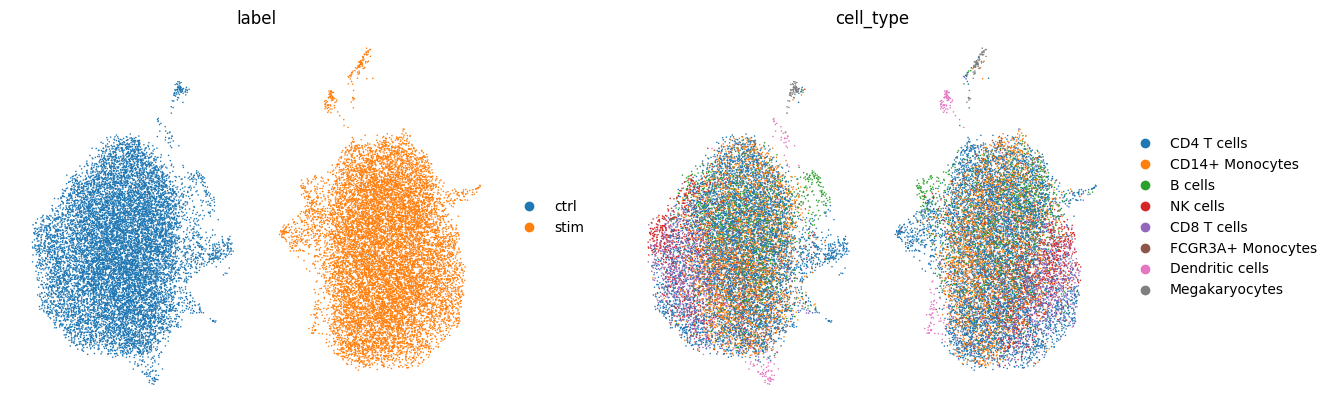

---UMAP for dis2p_cE_Z_2---


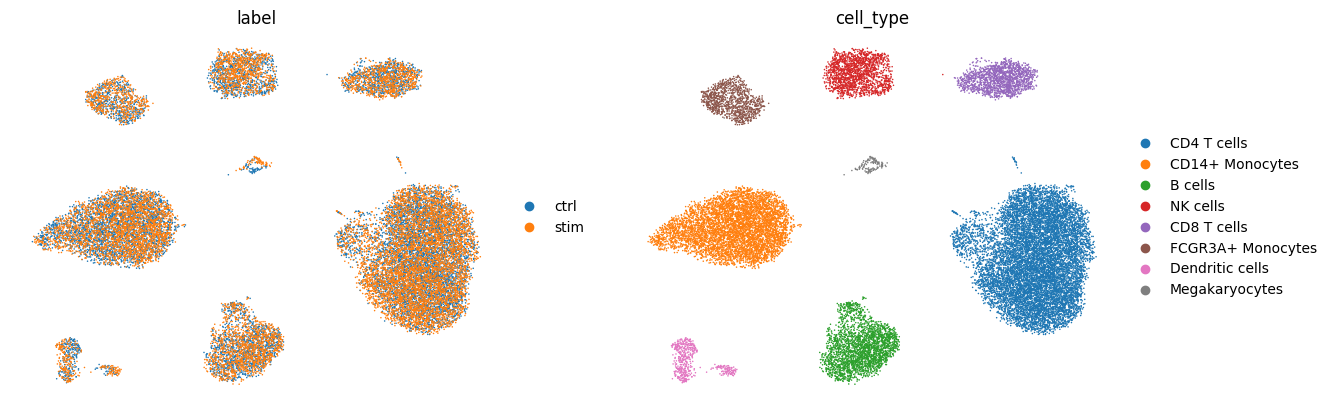

In [21]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## We notice that the UMAPs of dis2p and dis2p_cE look almost identical, and dis2p_cE_Z0 looks better ie less noisy.

## Train Biolord

In [37]:
from data.biolord_dev.src import biolord

In [38]:

biolord.Biolord.setup_anndata(
    adata=adata,
    ordered_attributes_keys=[],
    categorical_attributes_keys=cats,
    layer="counts"
)

In [39]:
# params in these cells are taken from here: https://biolord.readthedocs.io/en/latest/tutorials/biolord_omics.html#instantiate-a-biolord-model
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}
model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="kang_biolord_new",
    module_params=module_params,
)

Global seed set to 42


In [40]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}
model.train(
    max_epochs=400,
    batch_size=256,
    plan_kwargs=trainer_params,
    early_stopping=True,
    enable_checkpointing=False,
    early_stopping_patience=45,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 73/400:  18%|▏| 73/400 [02:50<12:42,  2.33s/it, v_num=1, val_generative_mean_accuracy=0.952, val_generative_var_accuracy=0.648, val_biolord_metric=0.8, val_reconstruction_loss=349, val_unk
Monitored metric val_biolord_metric did not improve in the last 45 records. Best score: 0.807. Signaling Trainer to stop.


In [42]:
model.save(f'models/biolord_kang_{today}')

In [44]:
for i, c in enumerate(cats):
    nullify_attribute = [cat for cat in cats if cat != c]
    _, latent_adata = model.get_latent_representation_adata(adata=adata, nullify_attribute=nullify_attribute)
    adata.obsm[f"biolord_{i+1}"] = latent_adata.X
    
adata.obsm[f"biolord"] = adata.obsm[f"biolord_2"]

## Train scVI

In [27]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="label")
vae = scvi.model.SCVI(adata)
vae.train()
vae.save("models/scVI")

adata.obsm["scVI"] = vae.get_latent_representation()

#vae = scvi.model.SCVI.load("models/scVI", adata=adata)




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 324/324: 100%|████████████████████████████████████████████████████████████████████████████████████████| 324/324 [21:47<00:00,  3.59s/it, v_num=1, train_loss_step=202, train_loss_epoch=205]

`Trainer.fit` stopped: `max_epochs=324` reached.


Epoch 324/324: 100%|████████████████████████████████████████████████████████████████████████████████████████| 324/324 [21:47<00:00,  4.04s/it, v_num=1, train_loss_step=202, train_loss_epoch=205]


## Train scanvi

In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
lvae.save("models/scANVI")
adata.obsm["scANVI"] = lvae_new.get_latent_representation()

#lvae_new = scvi.model.SCANVI.load("models/scANVI_new", adata=adata)


## Let's store PCA values

In [28]:
adata.obsm['PCA'] = adata.obsm['X_pca']


## Train Harmony

In [30]:
from harmony import harmonize

adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="label")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


## Let's benchmark using scIB

scib benchmark metrics for (batch_key=label, label_key=cell_type)


Metrics:  10%|██████████                                                                                          | 1/10 [00:00<00:06,  1.29it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]2024-01-16 15:30:37.414817: E external/xla/xla/stream_executor/gpu/gpu_graph.cc:52] Failed to trim Gpu device graph memory: Failed to trim device graph memory: CUDA_ERROR_SHARED_OBJECT_INIT_FAILED: shared object initialization failed

Metrics:   0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                  
Metrics:   0%|                                                                                                                                                             | 0/10 [00

<Figure size 6400x4800 with 0 Axes>

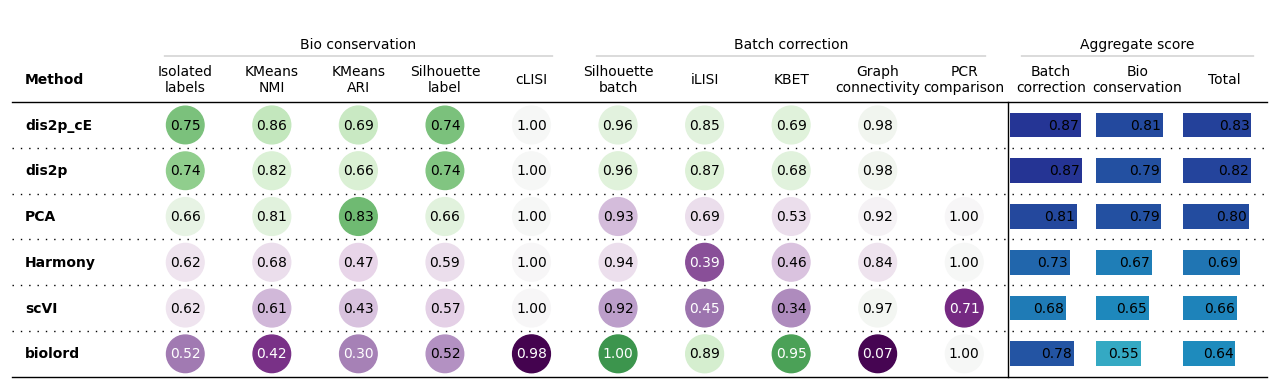

In [45]:
batch_key = cats[0]
label_key = cats[1]

print(f'scib benchmark metrics for (batch_key={batch_key}, label_key={label_key})')

bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=label_key,
    #embedding_obsm_keys=['PCA', 'scVI', 'scANVI', 'Harmony', 'LIGER', 'biolord', 'dis2p'],
    embedding_obsm_keys=['PCA', 'scVI', 'biolord', 'dis2p', 'dis2p_cE', 'Harmony'],
    n_jobs=-1,
)
bm.benchmark()

plt.figure(dpi=1000)
plt.savefig("metrics/scib.png")

bm.plot_results_table(min_max_scale=False)